In [1]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Categorical
import math
import torch.nn as nn

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(env.observation_space.shape, obs_dim, action_dim)

(4,) 4 2


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class ActionNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(ActionNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return F.softmax(self.layers(x))
    
class QValueNetwork(nn.Module):
    def __init__(self, in_dim: int, action_dim: int):
        '''状态价值，用来评估动作的好坏程度'''
        super(QValueNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, action_dim)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

In [14]:
actor = ActionNetwork(obs_dim, action_dim)
critic = QValueNetwork(obs_dim, action_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)

In [15]:
def select_action(state):
    '''策略网络做出决策，给出一个动作，并让智能体执行'''
    action_probs = actor(torch.FloatTensor(state).to(device))
    m = Categorical(action_probs)
    action = m.sample()
    loss = m.log_prob(action)
    return action.item(), loss

def critic_value(state, action):
    index_tensor = torch.tensor([action])
    return critic(torch.FloatTensor(state).to(device)).gather(0, index_tensor)

In [16]:
gamma = 0.98

steps = []
U_s = []
view_losses = []
max_epoch = 1000
for i in range(max_epoch):
    score = 0
    step = 0
    
    state, _ = env.reset(seed=3)
    while True:
        action, loss = select_action(state)
        '''从环境中观测到奖励和新的状态'''
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        step += 1
        
        mask = 1 - done
        
        '''根据策略网络做决策,但不让智能体执行动作'''
        next_action, next_loss = select_action(next_state)
        '''让价值网络打分'''
        q_t = critic_value(state, action)
        next_q_t = critic_value(next_state, next_action)
        '''计算价值网络的 TD 目标和 TD 误差'''
        y_t = reward + gamma * next_q_t * mask
        state_loss = F.smooth_l1_loss(q_t, y_t)
        '''更新价值网络'''
        critic_optimizer.zero_grad()
        state_loss.backward()
        critic_optimizer.step()
        '''更新策略网络'''
#         print(q_t.item())
        loss = -q_t.item() * loss
        actor_optimizer.zero_grad()
        loss.backward()
        actor_optimizer.step()
        
        if done or step > 200:
            steps.append(step)
            break
        
        state = next_state

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


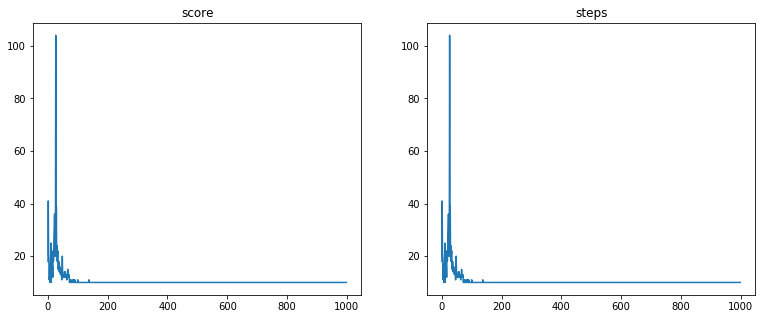

In [17]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
# plt.subplot(133)
# plt.title('epsilons')
# plt.plot(epsilons)
plt.show()